In [32]:
import torch
import triton

BLOCK_SIZE = 64
GROUP_SIZE = 8
device = torch.device("cuda")

from triton_mm import launch_smem_triton_matmul

In [33]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_smem_triton_matmul(out, a, b, M, N, K, a.stride(0), a.stride(1),
                              b.stride(0), b.stride(1), out.stride(0),
                              out.stride(1), BLOCK_SIZE, GROUP_SIZE)
    torch.cuda.synchronize()
    return out

In [34]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    out_torch = torch.matmul(a, b)
    out_triton = matmul(a, b)
    assert torch.allclose(out_torch, out_triton,
                          atol=5e-4), (size, out_torch[0][0].item(),
                                       out_triton[0][0].item())

In [35]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['triton', 'torch'],
                             line_names=[
                                 "Triton",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="smem-triton-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

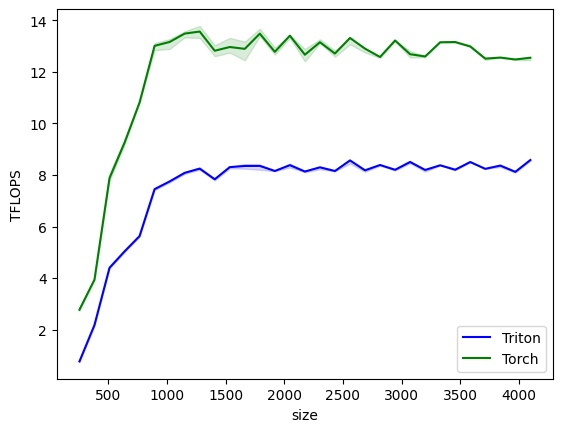

smem-triton-matmul-perf:
      size    Triton      Torch
0    256.0  0.767064   2.774011
1    384.0  2.180495   3.940917
2    512.0  4.398851   7.876628
3    640.0  5.034260   9.251271
4    768.0  5.630778  10.812126
5    896.0  7.450729  13.008593
6   1024.0  7.748844  13.158600
7   1152.0  8.081831  13.482642
8   1280.0  8.246634  13.562914
9   1408.0  7.833011  12.818283
10  1536.0  8.304030  12.963164
11  1664.0  8.349721  12.891558
12  1792.0  8.352180  13.482085
13  1920.0  8.154549  12.776340
14  2048.0  8.380948  13.403343
15  2176.0  8.134053  12.663850
16  2304.0  8.296380  13.148006
17  2432.0  8.153330  12.710090
18  2560.0  8.564978  13.314574
19  2688.0  8.181482  12.898904
20  2816.0  8.387146  12.576128
21  2944.0  8.201352  13.216259
22  3072.0  8.504921  12.684121
23  3200.0  8.194393  12.596062
24  3328.0  8.375296  13.146769
25  3456.0  8.202653  13.156731
26  3584.0  8.502361  12.983762
27  3712.0  8.238277  12.513294
28  3840.0  8.364864  12.553765
29  3968.0  8.1

In [36]:
benchmark.run(show_plots=True, print_data=True)

In [37]:
torch.cuda.empty_cache()